# Задание
Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе 
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым 

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

# Решение

## Импорты

In [ ]:
import os
import time
import re

from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, MaxPooling1D, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

## Предподготовка данных

In [ ]:
!wget -q https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

In [ ]:
!unzip -qo 20writers -d writers/

In [ ]:
# Константы

DIR_PATH = '/content/writers'

CLASS_LIST = []
TEXT_TRAIN = []
TEXT_TEST = []
CLASS_COUNT = 0
LEN_CLASSES = []

DIV = 0.8

In [ ]:
class timex():
    def __enter__(self):
        self.time = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        print('Время обработки: {:.2f} сек. \n\n'.format(time.time(), self.time))

In [ ]:
# Распределение данных по классам и тд

for cls in sorted(os.listdir(DIR_PATH)):
    with open(f'{DIR_PATH}/{cls}', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('\n', ' ').split(' ')
        div = int(len(text) * DIV)
        TEXT_TRAIN.append(' '.join(text[:div]))
        TEXT_TEST.append(' '.join(text[div:]))

    CLASS_LIST.append(cls[:len(cls) - 4])

CLASS_COUNT = len(CLASS_LIST)

print(CLASS_LIST)
print(CLASS_COUNT)

['Беляев', 'Булгаков', 'Васильев', 'Гоголь', 'Гончаров', 'Горький', 'Грибоедов', 'Достоевский', 'Каверин', 'Катаев', 'Куприн', 'Лермонтов', 'Лесков', 'Носов', 'Пастернак', 'Пушкин', 'Толстой', 'Тургенев', 'Чехов', 'Шолохов']
20


In [ ]:
# Функция вывода статистики
TEST_LEN_CLASSES = []

def get_stat(CLASS_COUNT, DATA):
    for cls in range(CLASS_COUNT):
        if len(LEN_CLASSES) >= 20:
            TEST_LEN_CLASSES.append(len(DATA[cls]))
        else:
            LEN_CLASSES.append(len(DATA[cls]))


        print(f'Класс: {CLASS_LIST[cls]} --- Длинна текста в классе: {len(DATA[cls])}')
        print(f'    Отрывок текста: {DATA[cls][:100]}')
        print()

    print(f'Общее количество классов: {CLASS_COUNT}')
    TRAIN_LEN_CLASSES = LEN_CLASSES[:20]

# print('ОБУЧАЮЩАЯ ВЫБОРКА')
# get_stat(CLASS_COUNT, TEXT_TRAIN)
# print('-------------')
# print('ТЕСТОВАЯ ВЫБОРКА')
# get_stat(CLASS_COUNT, TEXT_TEST)

In [ ]:

# # Функция вывода статистики по текстам

# def print_text_stats(title,                  # Заголовок для блока статистики
#                      texts,                  # Тексты в виде слов
#                      sequences,              # Тексты в виде индексов
#                      class_labels=CLASS_LIST # Список классов
#                      ):

#     chars = 0
#     words = 0

#     # Выведим заголовок
#     print(f'Статистика по {title} текстам:')

#     # Выведем итоги по всем классам данного набора текстов и их последовательностей индексов
#     for cls in range(len(class_labels)):
#         print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],      # Выводим количество имя класса, символом, слов
#                                                       len(texts[cls]),
#                                                       len(sequences[cls])))
#         chars += len(texts[cls])                                              # Готовим сумму всех символов
#         words += len(sequences[cls])                                          # Готовим сумму всех слов

#     print('----')
#     print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words)) # Выведем статистику по всему датасету


# with timex():
#     # Выведем итоги формирования выборок
#     print_text_stats('обучающим', TEXT_TRAIN, seq_train)
#     print_text_stats('тестовым', TEXT_TEST, seq_test)


In [ ]:
# Функция визуального отображения баланса между классами

def get_balance(CLASS_LIST, LEN_CLASSES):

    fig = plt.figure(figsize=(25, 4))
    ax = fig.add_subplot()
    ax.set_title('Баланс классов')

    x = np.array(CLASS_LIST)
    y = np.array(LEN_CLASSES)

    ax.set_xlabel('Класс')
    ax.set_ylabel('Количество символов')
    ax.bar(x, y)

Выборка вполне сбалансированна

In [ ]:
VOCAB_SIZE = 10000
WIN_SIZE = 1000
WIN_STEP = 500

## Токенизация

In [ ]:
# Функция токенизации выборки. Формирование словаря частотности

def make_tokenizer(VOCAB_SIZE, TEXT_TRAIN):
    tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                          filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True,
                          split=' ',
                          char_level=False,
                          oov_token='unknown_words',
                         )
    
    tokenizer.fit_on_texts(TEXT_TRAIN)

    items = list(tokenizer.word_index.items())
    example = list(tokenizer.word_counts.items())
    print(f'Словарь частности: {items[:15]}')
    print(f'Отрывок из словаря частности: {example[:15]}')

    return tokenizer

## Создание последовательности индексов

In [ ]:
# Функция создания последовательности индексов из строк выборки с помощью словаря частотности

def make_sequence(tokenizer, TEXT_TRAIN, TEXT_TEST):
    seq_train = tokenizer.texts_to_sequences(TEXT_TRAIN)

    if TEXT_TEST:
        seq_test = tokenizer.texts_to_sequences(TEXT_TEST)
    else:
        seq_test = None

    print(TEXT_TRAIN[0][:150])
    print(seq_train[0][:150])

    return seq_train, seq_test

## Разделение последовательности индексов на примеры

In [ ]:
# Последовательность индексов каждого класса разбиваем на множество примеров и формируем список меток

def split_sequences(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

In [ ]:
def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []

    for i in range(class_count):
        lst = split_sequences(seq_list[i], win_size, hop)
        x += lst
        y += [utils.to_categorical(i, class_count)] * len(lst)
    
    return np.array(x), np.array(y)

## Сервисные функции

In [ ]:
# Функция компиляции и обучения модели

def compile_train_model(model,
                        x_train, y_train,
                        x_val, y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20,5)):
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    display(plot_model(model, dpi=60, show_shapes=True))


    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))
                
    # Выведем графики точности и ошибки

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)            # Создадим набор графиков
    fig.suptitle('График процесса обучения модели')                  # Добавим заголовок
    ax1.plot(history.history['accuracy'],                            # Добавим график точности распознавания на первый рисунок
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],                        # Добавим график точности распознавания на тестовый данных на первый рисунок
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')                                 # Добавим подпись на горизонтальную ось
    ax1.set_ylabel('Доля верных ответов')                            # Добавим подпись на вертикальную ось
    ax1.legend()                                                     # Добавим легенду на рисунок

    ax2.plot(history.history['loss'],                                # Добавим график потерь на второй рисунок
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],                            # Добавим график потерь на тестовый данных   на второй рисунок
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')                                 # Добавим подпись на горизонтальную ось
    ax2.set_ylabel('Ошибка')                                         # Добавим подпись на вертикальную ось
    ax2.legend()                                                     # Добавим легенду на рисунок
    plt.show()                                                       # Отрисуем набор графиков

    # Вернем обученную модель
    return model

In [ ]:
# Функция вывода результатов оценки модели

def eval_model(model,
               x,
               y_true,
               class_labels=[],
               cm_round=2,
               title='',
               figsize=(20, 25)):

    y_pred = model.predict(x)

    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
 
    fig, ax = plt.subplots(figsize=figsize)                                          # Создадим шаблон для набора графиков
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)  # Добавим заголовок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)  # Подготовим матрицу ошибок к отрисовке
    disp.plot(ax=ax)                                                                 # Отрисуем матрицу
    plt.gca().images[-1].colorbar.remove()                                           # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=26)                                  # Зададим название горизонтальной оси
    plt.ylabel('Верные классы', fontsize=26)                                         # Зададим название вертикальной оси   
    fig.autofmt_xdate(rotation=45)                                                   # Наклон меток горизонтальной оси при необходимости
    plt.show()                                                                       # Отрисуем набор графиков

    print('-'*100)
    print(f'Нейросеть: {title}')                                                     # Выведем название сети

    # Для каждого класса:

    for cls in range(len(class_labels)):

        # Определяем индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])

        # Формируем сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('

        # Выводим текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                   # Необученная модель
                             x_train,                 # Обучающая выборка текста
                             y_train,                 # Обучающая выборка меток классов
                             x_test,                  # Тестовая выборка текста
                             y_test,                  # Тестовая выборка меток классов
                             class_labels=CLASS_LIST, # Список названий классов
                             title='',                # Общий заголовок 
                             optimizer='adam',        # Используемый оптимайзер
                             epochs=50,               # Количество эпох
                             batch_size=128,          # Размер батча
                             graph_size=(20, 5),      # Размер графиков результатов обучения
                             cm_size=(15, 15)         # Размер графиков результатов проверки
                             ):   

    # Скомпилируем и обучим модель на заданных параметрах
    # В качестве проверочных используем тестовые данные
    model = compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Выведем результаты оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)
    return model

## Сборка

Класс: Беляев --- Длинна текста в классе: 1804564
    Отрывок текста: ﻿Часть первая  I. На палубе   Большой трансатлантический пароход «Вениамин Франклин» стоял в генуэзс

Класс: Булгаков --- Длинна текста в классе: 1616636
    Отрывок текста: ﻿Черновики романа. Тетрадь 1 1928 - 1929 гг. РАЗГОВОР ПО ДУШАМ - Значит, гражданин Поротый, две тыся

Класс: Васильев --- Длинна текста в классе: 2354798
    Отрывок текста: ﻿А зори здесь тихие…1  В списках не значилсяЧасть первая1   На 171-м разъезде уцелело двенадцать дво

Класс: Гоголь --- Длинна текста в классе: 1573975
    Отрывок текста: ﻿Гоголь Николай Васильевич. Мертвые души. Поэма.  We may guess that it was a pretty apt expression, 

Класс: Гончаров --- Длинна текста в классе: 2460584
    Отрывок текста: ﻿Обломов ЧАСТЬ ПЕРВАЯ I В Гороховой улице, в одном из больших домов, народонаселения которого стало 

Класс: Горький --- Длинна текста в классе: 2013335
    Отрывок текста: ﻿МАКАР ЧУДРА* С моря дул влажный, холодный ветер, разнося по ст

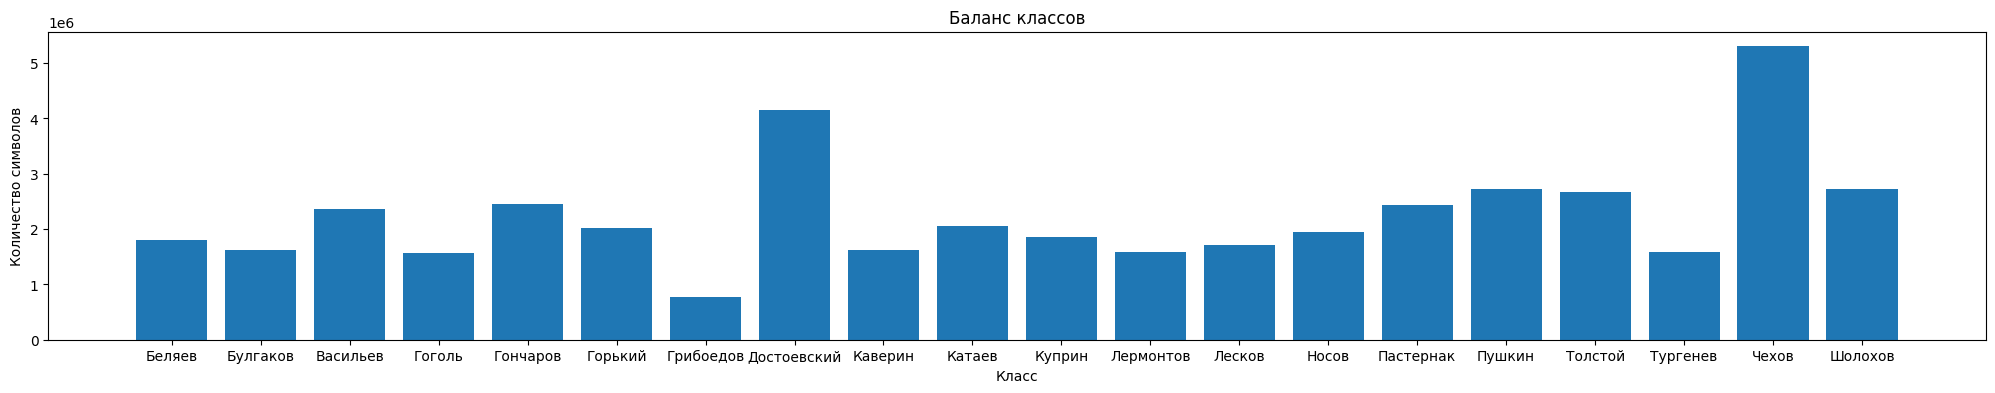

In [ ]:
# Собираем все

get_stat(CLASS_COUNT, TEXT_TRAIN)
get_stat(CLASS_COUNT, TEXT_TEST)

get_balance(CLASS_LIST, LEN_CLASSES)

tok = make_tokenizer(VOCAB_SIZE, TEXT_TRAIN)
seq_train, seq_test = make_sequence(tok, TEXT_TRAIN, TEXT_TEST)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_STEP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_STEP)

## Модели

In [ ]:
def make_model_LSTM(VOCAB_SIZE, WIN_SIZE, CLASS_COUNT):
    model = Sequential()

    model.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.4))

    model.add(Bidirectional(LSTM(8, return_sequences=True)))
    model.add(Bidirectional(LSTM(8)))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    return model

In [ ]:
def make_model_Conv1D(VOCAB_SIZE, # Размер словаря
             WIN_SIZE,   # Размер данных
             CLASS_COUNT # Количество классов текстов
             ):

    # Создадим модель

    model = Sequential() 
    model.add(Embedding(VOCAB_SIZE, 30, input_length=WIN_SIZE)) # Добавим эмбеддинг
    model.add(SpatialDropout1D(0.2))                            # Добавим дропаут для целых векторов в эмбеддинг пространстве 
    model.add(BatchNormalization())                             # Добавим нормализацию по батчу
    model.add(Conv1D(20, 3, activation='relu'))                 # Добавим слой одномерной свертки Conv1D
    model.add(Conv1D(20, 3, activation='relu'))                 # Добавим слой одномерной свертки Conv1D
    model.add(MaxPooling1D(2))                                  # Добавим слой подвыборки/пулинга с функцией максимума
    model.add(Dropout(0.2))                                     # Добавим простой дропаут  с долей отключаемых нейронов 0.2
    model.add(BatchNormalization())                             # Добавим нормализацию по батчу
    model.add(Flatten())                                        # Перегоним выход предыдущего слоя в одномерный массив
    model.add(Dense(100, activation='relu'))                    # Добавим dense слой с числом нейронов =100
    model.add(Dense(CLASS_COUNT, activation='softmax'))         # Добавим выходной dense слой с числом нейронов равным числу распознаваемых классов 

    # Вернем модель
    return model

In [ ]:
def main(model, epochs, batch_size):
    with timex():
        compile_train_eval_model(model,                   # Необученная модель
                                x_train,                 # Обучающая выборка текста
                                y_train,                 # Обучающая выборка меток классов
                                x_test,                  # Тестовая выборка текста
                                y_test,                  # Тестовая выборка меток классов
                                class_labels=CLASS_LIST, # Список названий классов
                                title='Авторы',                # Общий заголовок 
                                epochs=epochs,               # Количество эпох
                                batch_size=batch_size,          # Размер батча
                                )

In [ ]:
model_LSTM = make_model_LSTM(VOCAB_SIZE, WIN_SIZE, CLASS_COUNT)
model_Conv1D= make_model_Conv1D(VOCAB_SIZE, WIN_SIZE, CLASS_COUNT)

## Результаты

In [ ]:
# main(model_LSTM, 50, 200)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 30)          300000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 1000, 30)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 30)         120       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 998, 20)           1820      
                                                                 
 conv1d_5 (Conv1D)           (None, 996, 20)           1220      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 498, 20)         

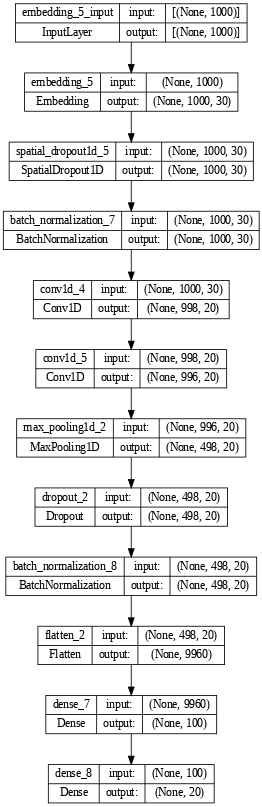

Epoch 1/50
70/70 [==============================] - 17s 209ms/step - loss: 3.2148 - accuracy: 0.1134 - val_loss: 3.5441 - val_accuracy: 0.0586
Epoch 2/50
70/70 [==============================] - 9s 132ms/step - loss: 1.6614 - accuracy: 0.4889 - val_loss: 5.1696 - val_accuracy: 0.1117
Epoch 3/50
70/70 [==============================] - 5s 76ms/step - loss: 0.6794 - accuracy: 0.7994 - val_loss: 6.6483 - val_accuracy: 0.0979
Epoch 4/50
70/70 [==============================] - 5s 65ms/step - loss: 0.2672 - accuracy: 0.9246 - val_loss: 6.7899 - val_accuracy: 0.0748
Epoch 5/50
70/70 [==============================] - 4s 51ms/step - loss: 0.1229 - accuracy: 0.9684 - val_loss: 7.9084 - val_accuracy: 0.0904
Epoch 6/50
70/70 [==============================] - 2s 33ms/step - loss: 0.0773 - accuracy: 0.9791 - val_loss: 6.5957 - val_accuracy: 0.1570
Epoch 7/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0648 - accuracy: 0.9810 - val_loss: 5.6812 - val_accuracy: 0.2194
Epoch 8/50

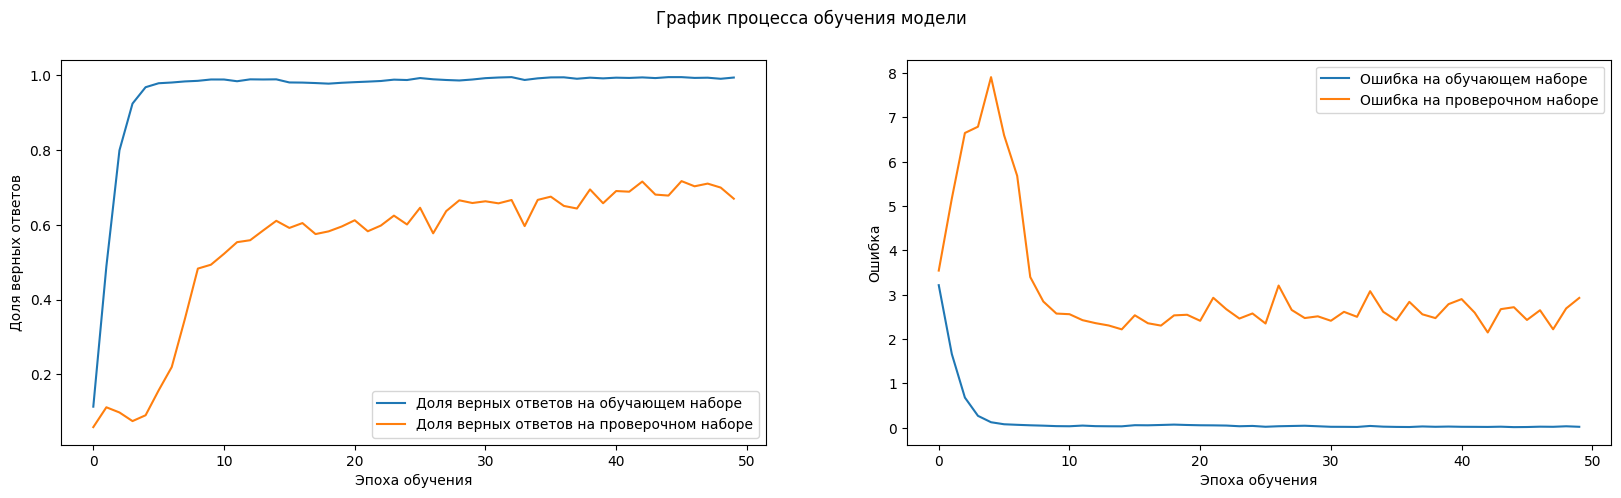

109/109 [==============================] - 1s 3ms/step


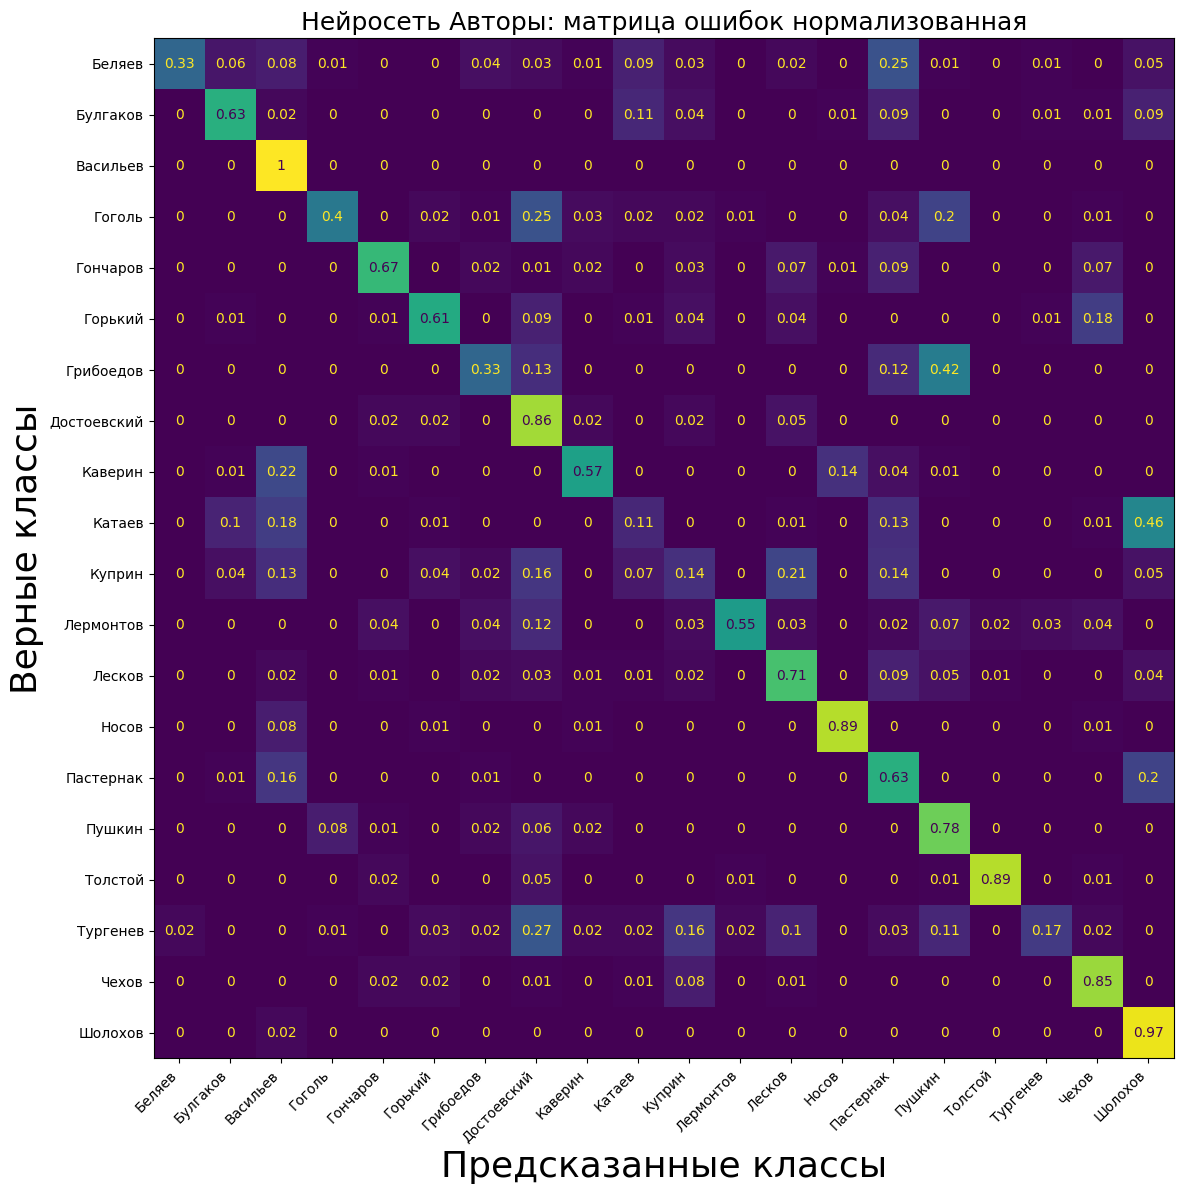

----------------------------------------------------------------------------------------------------
Нейросеть: Авторы
Класс: Беляев                33% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Булгаков              63% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Гоголь                40% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Гончаров              67% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Горький               61% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Грибоедов             42% сеть отнесла к классу Пушкин               - НЕВЕРНО :-(
Класс: Достоевский           86% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Каверин               57% сеть отнесла к классу Каверин              - ВЕРНО :-)
Класс: Катаев                46% сеть отнесла к классу Шолохов              - НЕВЕРНО :

In [ ]:
main(model_Conv1D, 50, 200)

# Сохранение модели

In [ ]:
model_Conv1D.save('model_Conv1D.h5')

# Загрузка своего текста

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_Conv1D.h5')

In [ ]:
file_kuprin = '/content/gdrive/MyDrive/Datasets/16 Реккурентные нейронные сети/Куприн.txt'
file_sholohov = '/content/gdrive/MyDrive/Datasets/16 Реккурентные нейронные сети/Шолохов.txt'

In [ ]:
def get_pred(model, file_name):

    pred_text = []

    with open(file_name, 'r') as f:
        text = f.read()
        text = text.replace('/n', ' ')
        pred_text.append(text)


    with timex():
        seq_val, _ = make_sequence(tok, pred_text, None)
        x_val, _ = vectorize_sequence(seq_val, WIN_SIZE, WIN_STEP)
    
    # Выведем размер проверочной выборки
    print(x_val.shape)

    # Выполним распознавание писателя
    y_pred = model.predict(x_val)

    # Разберем результаты предсказания

    r = np.argmax(y_pred, axis=1)                     # Найдем индексы писателей
    unique, counts = np.unique(r, return_counts=True) # Найдем полученые индексы и их количество
    counts = counts/y_pred.shape[0]*100               # Считаем долю каждного полученного индекса 
    print(unique, counts)                             # Выведем полученые индексы и их доли


    # Выведем результат предсказания

    for i in range(len(unique)):
        print('{:10s} - {:<.2f}%'.format(CLASS_LIST[unique[i]],counts[i]))

In [ ]:
get_pred(model_Conv1D, file_kuprin)

Следующий рассказ не есть плод досужего вымысла. Все описанное мною действительно произошло в Киеве лет около тридцати тому назад и до сих пор свято, 
[2028, 1390, 4, 65, 1, 1, 1, 21, 1, 532, 428, 1479, 3, 1, 171, 260, 3343, 250, 239, 2, 45, 668, 340, 1, 45, 1, 9778, 1, 3, 1, 92, 4625, 31, 410, 1429, 911, 8, 7, 119, 297, 365, 8793, 5055, 2035, 1, 2042, 165, 1, 1190, 29, 1, 1, 1, 1, 5247, 1, 10, 1, 1672, 427, 1, 12, 3284, 29, 10, 10, 63, 3180, 12, 19, 51, 999, 999, 1, 63, 3180, 81, 457, 1, 40, 3190, 12, 2, 965, 1, 1, 103, 6507, 22, 1, 2484, 2290, 1, 6164, 3581, 1, 8218, 9770, 173, 373, 3, 1796, 9952, 15, 970, 1, 25, 1, 1, 43, 46, 152, 1399, 502, 6007, 103, 165, 1, 1, 1, 3, 1, 1130, 47, 1, 2, 1, 115, 1, 8293, 2013, 1, 1, 1, 1780, 956, 2663, 1, 1, 2, 1, 634, 1, 1, 1, 2053, 1, 356, 1, 47]
Время обработки: 1681517940.08 сек. 


(3, 1000)
1/1 [==============================] - 0s 92ms/step
[10 14] [66.66666667 33.33333333]
Куприн     - 66.67%
Пастернак  - 33.33%


In [ ]:
get_pred(model_Conv1D, file_sholohov)

Первая послевоенная весна была  на  Верхнем Дону на  редкость дружная и
напористая. В конце марта из Приазовья подули теплые ветры, и уже через двое
с
[1220, 1, 4005, 61, 5, 1, 3841, 5, 8318, 1, 2, 1, 3, 656, 3622, 22, 1, 1, 9758, 1, 2, 46, 101, 965, 3588, 1, 1, 1, 1, 3513, 3, 2007, 1, 1, 3209, 1, 2, 1, 1, 3743, 7434, 1, 1, 6994, 2, 731, 303, 167, 158, 1, 3, 184, 1, 2360, 1, 30, 823, 572, 3, 7382, 1, 2, 6385, 6694, 172, 365, 260, 1, 6979, 15, 1, 47, 1331, 4, 23, 12, 198, 42, 7, 8328, 5022, 45, 1, 935, 3514, 1, 643, 3, 1, 1, 1, 1831, 1, 6199, 1, 4180, 17, 1367, 1, 1, 3, 1, 1, 68, 3209, 2, 1, 2702, 2, 101, 407, 5, 1, 1, 2, 1, 56, 5930, 1, 1, 46, 3522, 1132, 1, 1, 9572, 10, 3, 1, 1, 873, 7985, 2, 1, 1, 1, 75, 2, 1, 1, 9228, 1, 1, 1, 80, 60, 27, 357, 557, 7380]
Время обработки: 1681517951.67 сек. 


(8, 1000)
1/1 [==============================] - 0s 28ms/step
[ 2 14 19] [50.  12.5 37.5]
Васильев   - 50.00%
Пастернак  - 12.50%
Шолохов    - 37.50%
